In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import html
import re
import glob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import sent_tokenize

sid = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_lg")

In [3]:
path = r'E:/NSS/nss_data_science/Capstone/data/covid' 
all_tweets = glob.glob(path + "/*.csv")

### merge data to get larger sample

In [4]:
tweets = pd.concat([pd.read_csv(csv) for csv in glob.glob(path + "/*.CSV")], ignore_index=True)
tweets = tweets[tweets.lang == 'en']
tweets = tweets[['created_at', 'text','is_quote', 'favourites_count', 'retweet_count', 
                 'followers_count', 'friends_count', 'account_created_at', 'verified']]

In [30]:
#tweets.to_csv('tweets_421_430.csv', index=False)

In [3]:
tweets =  pd.read_csv('tweets_421_430.csv')

In [4]:
def clean(text):    

    text = html.unescape(text.lower())    
    text = re.sub(r'\n|#', '', text)
    text = re.sub(r'https:\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = " ".join([" ".join(re.findall(r'[A-Z][a-z]+',x)) \
                     if re.match(r'(?:[A-Z][a-z]+){2,}',x) else x for x in text.split()])

    return text

### because the distribution for retweet_count is extremely skewed, do a classification problem

In [5]:
retweet = tweets[tweets.retweet_count > 0].reset_index(drop=True)

In [6]:
retweet.retweet_count.describe()

count    690974.000000
mean          8.925517
std          85.487573
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max       18168.000000
Name: retweet_count, dtype: float64

In [7]:
ret = tweets[['text','retweet_count']]

### make sure the target classes are balanced when sampling

In [8]:
sample = pd.concat([ret[ret.retweet_count == 0].sample(n=10000, random_state = 42), 
                    ret[ret.retweet_count > 0].sample(n=10000, random_state = 42)])

In [9]:
sample['is_retweeted'] = [1 if x > 0 else 0 for x in sample.retweet_count]

In [10]:
#shuffle the data to make sure the balanced classes in both train and test set
sample = sample.sample(frac=1).reset_index(drop=True)

In [11]:
sample['text'] = [clean(text) for text in sample.text]

In [12]:
sample.shape

(20000, 3)

In [13]:
stopword = stopwords.words('english')

In [14]:
def remove_stopword(data):   
        
    tokens_list = []

    for token in data: 
        #can't -> [can, t]
        if len(token) > 1 and token not in stopword:
            tokens_list.append(token)
    return tokens_list

In [15]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[A-Za-z]+')


sample["tokens"] = [tokenizer.tokenize(x) for x in sample.text]
sample["tokens"] = [remove_stopword(tokens) for tokens in sample.tokens]
sample.head()

,text,retweet_count,is_retweeted,tokens
0,that feeling when your baby falls back asleep ...,0,0,"[feeling, baby, falls, back, asleep, nap, like..."
1,"day 34 of 84 shielding, but working. bit of ti...",0,0,"[day, shielding, working, bit, tik, tok, satur..."
2,"""as we reactivate our economy, we need to bet ...",4,1,"[reactivate, economy, need, bet, employment, o..."
3,please support this frontlineheroes organizati...,0,0,"[please, support, frontlineheroes, organizatio..."
4,i think bill belichick is social distancing th...,0,0,"[think, bill, belichick, social, distancing, p..."


In [16]:
#[x for x in sample.text[0:] if x.isalpha()]

In [17]:
import gensim

In [18]:
# skip-gram
w2v_model = gensim.models.Word2Vec(sample.tokens, size=300, min_count=2, sg=1) 

In [19]:
def w2v_mean(data):   
        
    tokens_list = []

    for token in data: 
        if w2v_model.wv.__contains__(token):
            tokens_list.append(token)
            
    if tokens_list == []:
        return np.zeros(300)
    else:
        return w2v_model.wv.__getitem__(tokens_list).mean(axis=0)

In [20]:
#sample.text[3657]

In [21]:
#w2v_model.wv.__getitem__('daylockdown')

In [22]:
sample['mean_word_embedding'] = [w2v_mean(x) for x in sample.tokens]

In [23]:
sample.text[0]

'that feeling when your baby falls back asleep during her nap... it\'s like that introvert moment of happiness when plans get cancelled and you suddenly have a little extra free time. (with covid19 it\'s not really "free time" but "get all the work done time").'

In [24]:
w2v_model.wv.similar_by_vector(w2v_model.wv.__getitem__('night'))

[('night', 1.0),
 ('later', 0.9614809155464172),
 ('june', 0.9597132802009583),
 ('weekend', 0.959582507610321),
 ('goes', 0.9570226073265076),
 ('anniversary', 0.9512537717819214),
 ('morning', 0.9499289393424988),
 ('went', 0.9426701068878174),
 ('girl', 0.9413707256317139),
 ('oflockdown', 0.9400438666343689)]

In [25]:
sample.text[271]

'the dac clerks office will receive all voters with a smile but she reminds us that the only way to guarantee a safe way to vote this year is to vote by absentee ballot. covid19'

In [36]:
# how close these words(skip-gram), meaning that they have similar surrounding text
w2v_model.wv.similar_by_word('fuck')

[('straight', 0.9907780885696411),
 ('game', 0.9885056614875793),
 ('happens', 0.9881687760353088),
 ('anymore', 0.9877868890762329),
 ('boy', 0.9876819849014282),
 ('scared', 0.9864504337310791),
 ('ya', 0.9864210486412048),
 ('heard', 0.9863814115524292),
 ('tired', 0.9863635301589966),
 ('lol', 0.9857218265533447)]

In [31]:
sample.loc[sample.text.str.contains('fuck') & sample.text.str.contains(r'straight')].text.values

array([], dtype=object)

In [28]:
sample.text[15]

'essentialservices – today online and in paper we are featuring throughout the day a check in with our local essentialservices to see how they are managing during the coronavirus crisis.'

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [38]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(sample.mean_word_embedding, 
                                                                                        sample.is_retweeted, 
                                                                                        test_size=0.2, random_state=40)

In [43]:
def plot_LSA(data, labels, plot=True):
        pca = PCA(n_components=2)
        pca.fit(data)
        scores = pca.transform(data)
        color_mapper = {label:idx for idx,label in enumerate(set(labels))}
        color_column = [color_mapper[label] for label in labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(scores[:,0], scores[:,1], s=8, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Retweets')
            green_patch = mpatches.Patch(color='blue', label='Non-retweets')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

### It seems like these two classes are almost overlapping, probably the word embeddings are not reasonable

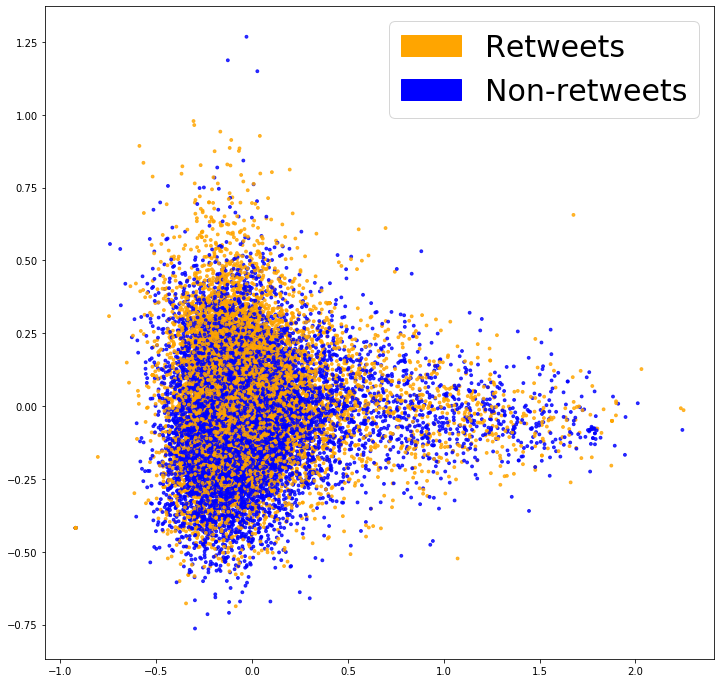

In [44]:
fig = plt.figure(figsize=(12, 12))          
plot_LSA(list(sample.mean_word_embedding), sample.is_retweeted)
plt.show()

In [45]:
LR = LogisticRegression(C=30.0, solver='newton-cg', random_state=42)
LR.fit(list(X_train_word2vec), y_train_word2vec)
y_predicted_word2vec = LR.predict(list(X_test_word2vec))

In [48]:
print(classification_report(y_train_word2vec, LR.predict(list(X_train_word2vec))))

              precision    recall  f1-score   support

           0       0.62      0.61      0.61      8041
           1       0.61      0.62      0.62      7959

    accuracy                           0.61     16000
   macro avg       0.61      0.61      0.61     16000
weighted avg       0.61      0.61      0.61     16000



In [49]:
print(classification_report(y_test_word2vec, LR.predict(list(X_test_word2vec))))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1959
           1       0.60      0.60      0.60      2041

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.60      4000
weighted avg       0.60      0.60      0.60      4000



### non-text features

In [50]:
ret_2 = tweets[['created_at','is_quote', 'text', 'favourites_count', 'retweet_count', 
                 'followers_count', 'friends_count', 'account_created_at', 'verified']]

In [51]:
sample_2 = pd.concat([ret_2[ret_2.retweet_count == 0].sample(n = 100000, random_state = 42), 
                      ret_2[ret_2.retweet_count > 0].sample(n = 100000, random_state = 42)])

In [52]:
sample_2.retweet_count.describe()

count    200000.000000
mean          4.632825
std          75.003053
min           0.000000
25%           0.000000
50%           0.500000
75%           2.000000
max       18168.000000
Name: retweet_count, dtype: float64

In [53]:
sample_2['length_text'] = [len(re.sub(r'\W+', '', x)) for x in sample_2.text]

In [54]:
sample_2['number_hashtag'] = [len(re.findall(r'#', x)) for x in sample_2.text] 
sample_2['number_at'] = [len(re.findall(r'@', x)) for x in sample_2.text] 

In [55]:
sample_2.created_at = pd.to_datetime(sample_2.created_at)
sample_2.account_created_at = pd.to_datetime(sample_2.account_created_at)

In [56]:
sample_2['created_weekday'] = sample_2.created_at.dt.weekday

In [57]:
sample_2['created_hour'] = sample_2.created_at.dt.hour

In [58]:
sample_2['time_delta'] = sample_2.created_at - sample_2.account_created_at
sample_2.time_delta = sample_2.time_delta.dt.days

In [59]:
#sample_2['sentiment_score'] = [sid.polarity_scores(x)['compound'] for x in sample_2.text]

In [60]:
sample_2 = sample_2.drop(['created_at', 'text', 'account_created_at'], axis=1)

In [61]:
sample_2.is_quote = [1 if x == True else 0 for x in sample_2.is_quote]

In [62]:
sample_2.verified = [1 if x == True else 0 for x in sample_2.verified]

In [63]:
sample_2.retweet_count = [1 if x > 0 else 0 for x in sample_2.retweet_count]

In [64]:
sample_2[['created_weekday','created_hour']] = sample_2[['created_weekday','created_hour']].astype('str')

In [65]:
sample_2 = pd.get_dummies(sample_2, drop_first=True)

In [66]:
sample_2.head()

,is_quote,favourites_count,retweet_count,followers_count,friends_count,verified,length_text,number_hashtag,number_at,time_delta,...,created_hour_21,created_hour_22,created_hour_23,created_hour_3,created_hour_4,created_hour_5,created_hour_6,created_hour_7,created_hour_8,created_hour_9
1912635,0,905,0,865,864,0,94,2,0,4177,...,0,0,0,0,0,0,0,0,0,0
1843997,0,2,0,26336,25383,0,139,2,0,3577,...,0,0,0,0,0,0,0,0,0,0
1810746,0,24016,0,6973,2148,0,98,6,1,3150,...,0,0,0,0,0,0,0,0,0,0
752248,0,778,0,2903,4577,1,232,12,0,2870,...,0,0,0,0,0,0,0,0,1,0
642382,0,226,0,344,368,0,122,3,1,3353,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
X = sample_2.drop(['retweet_count'], axis=1)
y = sample_2.retweet_count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [68]:
#sample_2[['ratio_follower_friend','favourites_per_day', 'followers_per_day', 'friends_per_day']].describe()

In [69]:
#sample_2[sample_2.favourites_per_day == np.inf][['favourites_count', 'time_delta', 'favourites_per_day']]

### Use random forest

In [93]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

### only twenty thousand samples 

In [77]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6983
           1       1.00      1.00      1.00      7017

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000



In [78]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      3017
           1       0.67      0.63      0.65      2983

    accuracy                           0.66      6000
   macro avg       0.66      0.66      0.66      6000
weighted avg       0.66      0.66      0.66      6000



### add more samples (200k)

In [67]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     70149
           1       0.99      0.98      0.99     69851

    accuracy                           0.99    140000
   macro avg       0.99      0.99      0.99    140000
weighted avg       0.99      0.99      0.99    140000



In [68]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69     29851
           1       0.70      0.64      0.67     30149

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.68      0.68      0.68     60000



### hour, day

In [57]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70149
           1       1.00      1.00      1.00     69851

    accuracy                           1.00    140000
   macro avg       1.00      1.00      1.00    140000
weighted avg       1.00      1.00      1.00    140000



In [58]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71     29851
           1       0.72      0.65      0.68     30149

    accuracy                           0.70     60000
   macro avg       0.70      0.70      0.70     60000
weighted avg       0.70      0.70      0.70     60000



### length of text, number of hashtag and mention 

In [40]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70149
           1       1.00      1.00      1.00     69851

    accuracy                           1.00    140000
   macro avg       1.00      1.00      1.00    140000
weighted avg       1.00      1.00      1.00    140000



In [41]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73     29851
           1       0.74      0.68      0.71     30149

    accuracy                           0.72     60000
   macro avg       0.72      0.72      0.72     60000
weighted avg       0.72      0.72      0.72     60000



### more features('ratio_follower_friend','favourites_per_day', 'followers_per_day', 'friends_per_day','follower_minus_friend')

### the model did not get improved

In [49]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70149
           1       1.00      1.00      1.00     69851

    accuracy                           1.00    140000
   macro avg       1.00      1.00      1.00    140000
weighted avg       1.00      1.00      1.00    140000



In [50]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73     29851
           1       0.74      0.68      0.71     30149

    accuracy                           0.72     60000
   macro avg       0.72      0.72      0.72     60000
weighted avg       0.72      0.72      0.72     60000



### add sentiment score

### the model did not get improved

In [146]:
print(classification_report(y_train, rf_model.predict(X_train)))

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70149
           1       1.00      1.00      1.00     69851

    accuracy                           1.00    140000
   macro avg       1.00      1.00      1.00    140000
weighted avg       1.00      1.00      1.00    140000



In [147]:
print(classification_report(y_test, rf_model.predict(X_test)))

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


              precision    recall  f1-score   support

           0       0.70      0.76      0.73     29851
           1       0.74      0.67      0.71     30149

    accuracy                           0.72     60000
   macro avg       0.72      0.72      0.72     60000
weighted avg       0.72      0.72      0.72     60000



### 500,000 samples (sligtly improved but overfitting)

In [94]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    350187
           1       1.00      1.00      1.00    349813

    accuracy                           1.00    700000
   macro avg       1.00      1.00      1.00    700000
weighted avg       1.00      1.00      1.00    700000



In [95]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74    149813
           1       0.75      0.69      0.72    150187

    accuracy                           0.73    300000
   macro avg       0.73      0.73      0.73    300000
weighted avg       0.73      0.73      0.73    300000



### GridSearch to tune the hyperprameter

In [140]:
params_rf = {
'n_estimators': [10, 20, 50, 100],
'max_depth': [2, 4, 6, 8],
'min_samples_leaf': [0.1, 0.2, 0.3],
'max_features': [None,'log2']
}
# Instantiate 'grid_rf'
grid_rf = GridSearchCV(estimator=rf_model,
param_grid=params_rf,
cv=5,
scoring='f1',
verbose=1,
n_jobs=-1)

In [141]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.4min finished
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': [None, 'log2'],
                         'min_samples_leaf': [0.1, 0.2, 0.3],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [142]:
best_hyperparams = grid_rf.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 2, 'max_features': None, 'min_samples_leaf': 0.3, 'n_estimators': 10}


### the overall score decreases but the results for training and test data sets are very close

In [144]:
print(classification_report(y_train, grid_rf.predict(X_train)))

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


              precision    recall  f1-score   support

           0       0.67      0.70      0.68     70149
           1       0.68      0.65      0.67     69851

    accuracy                           0.68    140000
   macro avg       0.68      0.68      0.67    140000
weighted avg       0.68      0.68      0.67    140000



In [143]:
print(classification_report(y_test, grid_rf.predict(X_test)))

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:510: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


              precision    recall  f1-score   support

           0       0.66      0.70      0.68     29851
           1       0.68      0.65      0.67     30149

    accuracy                           0.67     60000
   macro avg       0.67      0.67      0.67     60000
weighted avg       0.67      0.67      0.67     60000



### XGB with same features

In [21]:
import xgboost as xgb

In [22]:
# DMatrix objects required by the XGBoost learning API.
retweet_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

gbm_param_grid = {'objective':['reg:logistic'],
                  'learning_rate': [0.1, 0.2],
                  'n_estimators': [300, 500],
                  'subsample': [0.1, 0.2],
                  'max_depth':[3,4],
                 }

gbm = xgb.XGBClassifier()

grid = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,
scoring='f1', cv=4, verbose=1,n_jobs=-1)

grid.fit(X_train, y_train)
print("Best parameters found: ",grid.best_params_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 24.0min finished


Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 500, 'objective': 'reg:logistic', 'subsample': 0.2}


In [42]:
#'learning_rate': [0.01, 0.1],'n_estimators': [300, 500],'subsample': [0.2, 0.3]}
#Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 500, 'objective': 'reg:logistic', 'subsample': 0.2}
print(classification_report(y_train, grid.predict(X_train)))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6983
           1       0.76      0.70      0.73      7017

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000



In [43]:
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      3017
           1       0.76      0.70      0.73      2983

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000



### The correlationship between variables

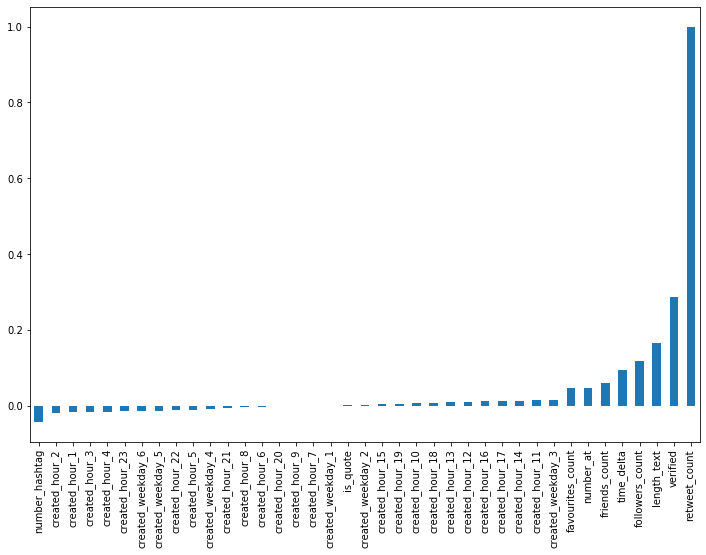

In [34]:
plt.figure(figsize=(12,8))
sample_2.corr()['retweet_count'].sort_values().plot(kind='bar')

### Deep learning (basic ANN with non-text features)

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [80]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

In [78]:
X = sample_2.drop(['retweet_count'], axis=1).values
y = sample_2.retweet_count.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [81]:
# different scale could make it hard to minima
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
X_train.shape

(150000, 38)

In [83]:
X_train

numpy.ndarray

In [45]:
model = Sequential()

model.add(Dense(units=38,activation='relu'))
model.add(Dense(units=19,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [102]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=200,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 150000 samples, validate on 50000 samples
Epoch 1/200
150000/150000 [==============================] - 8s 55us/sample - loss: 0.6364 - val_loss: 0.6267
Epoch 2/200
150000/150000 [==============================] - 8s 52us/sample - loss: 0.6272 - val_loss: 0.6225
Epoch 3/200
150000/150000 [==============================] - 8s 50us/sample - loss: 0.6249 - val_loss: 0.6205
Epoch 4/200
150000/150000 [==============================] - 7s 49us/sample - loss: 0.6235 - val_loss: 0.6208
Epoch 5/200
150000/150000 [==============================] - 8s 53us/sample - loss: 0.6224 - val_loss: 0.6185
Epoch 6/200
150000/150000 [==============================] - 8s 51us/sample - loss: 0.6210 - val_loss: 0.6171
Epoch 7/200
150000/150000 [==============================] - 8s 51us/sample - loss: 0.6196 - val_loss: 0.6210
Epoch 8/200
150000/150000 [==============================] - 8s 50us/sample - loss: 0.6183 - val_loss: 0.6158
Epoch 9/200
150000/150000 [==============================] - 8s 53us/

In [104]:
predictions = model.predict_classes(X_test)

In [105]:
print(classification_report(y_train,model.predict_classes(X_train)))

              precision    recall  f1-score   support

           0       0.64      0.80      0.71     75106
           1       0.73      0.56      0.63     74894

    accuracy                           0.68    150000
   macro avg       0.69      0.68      0.67    150000
weighted avg       0.69      0.68      0.67    150000



In [106]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71     24894
           1       0.73      0.56      0.63     25106

    accuracy                           0.67     50000
   macro avg       0.68      0.67      0.67     50000
weighted avg       0.68      0.67      0.67     50000



### dropout

In [107]:
model_dropout = Sequential()
model_dropout.add(Dense(units=38,activation='relu'))
model_dropout.add(Dropout(0.5))

model_dropout.add(Dense(units=19,activation='relu'))
model_dropout.add(Dropout(0.5))

model_dropout.add(Dense(units=1,activation='sigmoid'))
model_dropout.compile(loss='binary_crossentropy', optimizer='adam')

In [108]:
model_dropout.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 150000 samples, validate on 50000 samples
Epoch 1/600
150000/150000 [==============================] - 10s 64us/sample - loss: 0.6590 - val_loss: 0.6369
Epoch 2/600
150000/150000 [==============================] - 10s 65us/sample - loss: 0.6435 - val_loss: 0.6274
Epoch 3/600
150000/150000 [==============================] - 10s 65us/sample - loss: 0.6384 - val_loss: 0.6243
Epoch 4/600
150000/150000 [==============================] - 10s 65us/sample - loss: 0.6371 - val_loss: 0.6246
Epoch 5/600
150000/150000 [==============================] - 10s 65us/sample - loss: 0.6356 - val_loss: 0.6228
Epoch 6/600
150000/150000 [==============================] - 10s 66us/sample - loss: 0.6357 - val_loss: 0.6227
Epoch 7/600
150000/150000 [==============================] - 10s 66us/sample - loss: 0.6352 - val_loss: 0.6218
Epoch 8/600
150000/150000 [==============================] - 10s 68us/sample - loss: 0.6337 - val_loss: 0.6220
Epoch 9/600
150000/150000 [==============================] - 

In [110]:
print(classification_report(y_train,model_dropout.predict_classes(X_train)))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70     75106
           1       0.72      0.51      0.60     74894

    accuracy                           0.66    150000
   macro avg       0.67      0.66      0.65    150000
weighted avg       0.67      0.66      0.65    150000



In [111]:
print(classification_report(y_test,model_dropout.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70     24894
           1       0.72      0.51      0.60     25106

    accuracy                           0.66     50000
   macro avg       0.67      0.66      0.65     50000
weighted avg       0.67      0.66      0.65     50000

